In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
df = pd.read_csv('dataset/spotify_tracks.csv')

df.head()

,id,name,genre,artists,album,popularity,duration_ms,explicit
0,7kr3xZk4yb3YSZ4VFtg2Qt,Acoustic,acoustic,Billy Raffoul,1975,58,172199,False
1,1kJygfS4eoVziBBI93MSYp,Acoustic,acoustic,Billy Raffoul,A Few More Hours at YYZ,57,172202,False
2,6lynns69p4zTCRxmmiSY1x,Here Comes the Sun - Acoustic,acoustic,"Molly Hocking, Bailey Rushlow",Here Comes the Sun (Acoustic),42,144786,False
3,1RC9slv335IfLce5vt9KTW,Acoustic #3,acoustic,The Goo Goo Dolls,Dizzy up the Girl,46,116573,False
4,5o9L8xBuILoVjLECSBi7Vo,My Love Mine All Mine - Acoustic Instrumental,acoustic,"Guus Dielissen, Casper Esmann",My Love Mine All Mine (Acoustic Instrumental),33,133922,False


In [4]:
df_selected = df[['name', 'genre', 'artists', 'album', 'popularity', 'explicit']]
df_selected.head()

,name,genre,artists,album,popularity,explicit
0,Acoustic,acoustic,Billy Raffoul,1975,58,False
1,Acoustic,acoustic,Billy Raffoul,A Few More Hours at YYZ,57,False
2,Here Comes the Sun - Acoustic,acoustic,"Molly Hocking, Bailey Rushlow",Here Comes the Sun (Acoustic),42,False
3,Acoustic #3,acoustic,The Goo Goo Dolls,Dizzy up the Girl,46,False
4,My Love Mine All Mine - Acoustic Instrumental,acoustic,"Guus Dielissen, Casper Esmann",My Love Mine All Mine (Acoustic Instrumental),33,False


In [5]:
df_selected.isnull().sum()

name          0
genre         0
artists       0
album         0
popularity    0
explicit      0
dtype: int64

In [6]:
df_selected.dtypes

name          object
genre         object
artists       object
album         object
popularity     int64
explicit        bool
dtype: object

In [17]:
le = LabelEncoder()

encoders = {} 

for col in df_selected.select_dtypes(include=['object', 'bool']).columns:
    df_selected[col] = le.fit_transform(df_selected[col])
    encoders[col] = le

df_selected.head()

,name,genre,artists,album,popularity,explicit
0,71,0,496,39,58,0
1,71,0,496,91,57,0
2,1707,0,2697,1873,42,0
3,72,0,3880,1128,46,0
4,2534,0,1639,2764,33,0


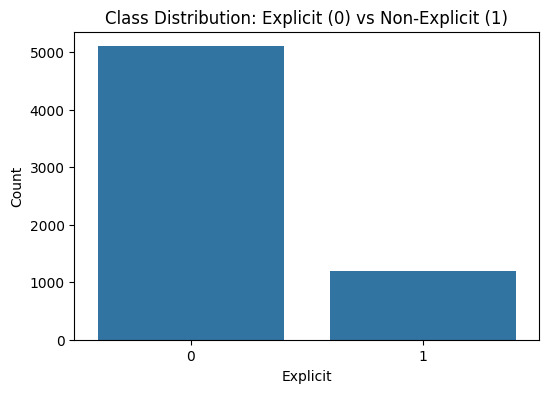

In [8]:
# Class distribution for the target variable (explicit)
plt.figure(figsize=(6, 4))
sns.countplot(x='explicit', data=df_selected, legend=False)
plt.title("Class Distribution: Explicit (0) vs Non-Explicit (1)")
plt.xlabel("Explicit")
plt.ylabel("Count")
plt.show()

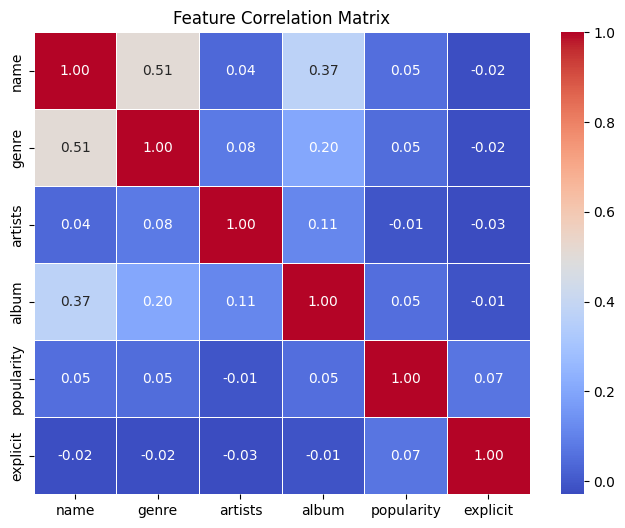

In [9]:
# Feature correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df_selected.corr()  # Compute correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [10]:
# Separate features and target
X = df_selected.drop('explicit', axis=1)
y = df_selected['explicit']

# Split the data (80% train, 20% test) using stratified sampling to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of the train and test sets
print(f"Training Set X: {X_train.shape}, Testing Set: {X_test.shape}")
print(f"Training Set Y: {y_train.shape}, Testing Set: {y_test.shape}")

# Check the distribution of the target variable in both sets
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Class distribution in testing set: \n{y_test.value_counts()}")


Training Set X: (5036, 5), Testing Set: (1260, 5)
Training Set Y: (5036,), Testing Set: (1260,)
Class distribution in training set: 
explicit
0    4082
1     954
Name: count, dtype: int64
Class distribution in testing set: 
explicit
0    1021
1     239
Name: count, dtype: int64


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)


[[ 1.34741954  1.55245446  1.31122199  1.16968005  1.07149163]
 [ 1.49300135 -0.08829853 -0.64344469  1.44462083  0.46881873]
 [-1.17311297 -1.15478798 -1.32096165 -0.45946777  1.12171438]
 ...
 [-0.4987151  -0.27971971 -0.62151612 -0.47218997 -0.53563612]
 [ 1.18767302  0.59534855  0.10288259  1.28983412  0.3181505 ]
 [-1.28170912 -1.29151739 -1.14628931 -1.14505276 -1.33919999]]


In [34]:
# Initialize Logistic Regression model with balanced class weights
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
X_scaled = scaler.fit_transform(X)
# Perform cross-validation with 5 folds using StratifiedKFold to preserve class distribution
cv_scores = cross_val_score(lr_model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')

# Print the cross-validation scores and the mean score
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy score from cross-validation: {cv_scores.mean()}")


# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, zero_division=1))


Cross-validation scores: [0.54444444 0.53455123 0.56791104 0.55599682 0.57426529]
Mean accuracy score from cross-validation: 0.5554337657753066
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.83      0.56      0.67      1021
           1       0.21      0.51      0.30       239

    accuracy                           0.55      1260
   macro avg       0.52      0.54      0.49      1260
weighted avg       0.71      0.55      0.60      1260



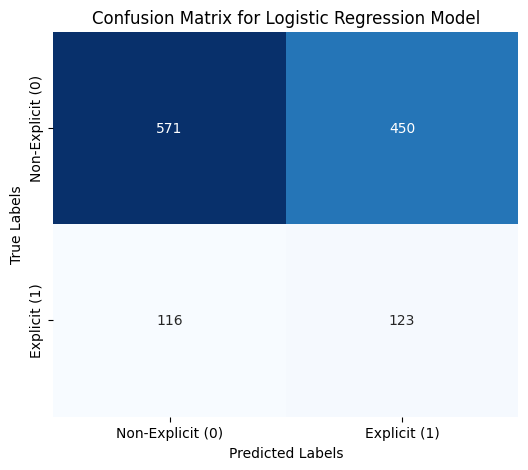

In [13]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Non-Explicit (0)", "Explicit (1)"], 
            yticklabels=["Non-Explicit (0)", "Explicit (1)"])

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression Model")

# Display the plot
plt.show()

In [14]:
# Initialize LabelEncoder and StandardScaler
le = LabelEncoder()
scaler = StandardScaler()

# Load the testing dataset
df_test = pd.read_csv('dataset/extracted_tracks.csv')  

# Select the same columns as in the training dataset
df_test_selected = df_test[['name', 'genre', 'artists', 'album', 'popularity']].copy()


# Initialize encoders dictionary to store the label encoders for each column
encoders = {}

# Apply LabelEncoder to categorical columns in the test set
for col in X_test.select_dtypes(include=['object']).columns:
    # Use the encoder that was fitted on the training data (not fitting a new encoder)
    if col in encoders:
        X_test[col] = encoders[col].transform(X_test[col])
    else:
        # If the encoder is not already saved, we fit it and save it
        le.fit(X_test[col])
        X_test[col] = le.transform(X_test[col])
        encoders[col] = le

# Convert the numerical columns to float before scaling
numerical_columns = ['popularity']

# Ensure the column is of type float64 before applying StandardScaler
X_test[numerical_columns] = X_test[numerical_columns].astype('float64')

# Apply StandardScaler to numerical columns (e.g., 'popularity')
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

# Now you can use X_test for predictions using the trained model
# Use the trained logistic regression model for prediction
pred = lr_model.predict(X_test)
prob = lr_model.predict_proba(X_test)

# Output predictions and confidence
for i, row in df_test_selected.iterrows():
    print(f"Track: {row['name']}")
    print(f"Prediction: {'Explicit' if pred[i] == 1 else 'Not Explicit'}")
    print(f"Confidence: {prob[i][pred[i]]:.2f}")
    print('---')

# If you want to evaluate the model's performance on the test set:
print("Logistic Regression Performance on Test Data:")
print(classification_report(y_test, pred, zero_division=1))


Track: French
Prediction: Not Explicit
Confidence: 1.00
---
Track: Bluegrass Is... (Reprise)
Prediction: Not Explicit
Confidence: 1.00
---
Track: Summer in Marseille
Prediction: Not Explicit
Confidence: 1.00
---
Track: Inertia - Acoustic
Prediction: Not Explicit
Confidence: 1.00
---
Logistic Regression Performance on Test Data:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1021
           1       1.00      0.00      0.00       239

    accuracy                           0.81      1260
   macro avg       0.91      0.50      0.45      1260
weighted avg       0.85      0.81      0.73      1260



c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize LabelEncoder and StandardScaler
le = LabelEncoder()
scaler = StandardScaler()

# Manually input your data as a dictionary
# Example data for testing
input_data = {
    'name': ['Track1', 'Track2', 'Track3'],  # Track names
    'genre': ['Pop', 'Rock', 'Jazz'],        # Genres
    'artists': ['Artist1', 'Artist2', 'Artist3'],  # Artists
    'album': ['Album1', 'Album2', 'Album3'],  # Albums
    'popularity': [85, 55, 78],               
                   
}

# Convert input data to DataFrame
df_test_selected = pd.DataFrame(input_data)

# Initialize encoders dictionary to store the label encoders for each column
encoders = {}

# Apply LabelEncoder to categorical columns in the input data
for col in df_test_selected.select_dtypes(include=['object']).columns:
    # Use the encoder that was fitted on the training data (not fitting a new encoder)
    if col in encoders:
        df_test_selected[col] = encoders[col].transform(df_test_selected[col])
    else:
        # If the encoder is not already saved, we fit it and save it
        le.fit(df_test_selected[col])
        df_test_selected[col] = le.transform(df_test_selected[col])
        encoders[col] = le

# Convert the numerical columns to float before scaling
numerical_columns = ['popularity']

# Ensure the column is of type float64 before applying StandardScaler
df_test_selected[numerical_columns] = df_test_selected[numerical_columns].astype('float64')

# Apply StandardScaler to numerical columns (e.g., 'popularity')
df_test_selected[numerical_columns] = scaler.fit_transform(df_test_selected[numerical_columns])


pred = lr_model.predict(X_test)
prob = lr_model.predict_proba(X_test)

# Output predictions and confidence
for i, row in df_test_selected.iterrows():
    print(f"Track: {row['name']}")
    print(f"Prediction: {'Explicit' if pred[i] == 1 else 'Not Explicit'}")
    print(f"Confidence: {prob[i][pred[i]]:.2f}")
    print('---')



Track: 0.0
Prediction: Not Explicit
Confidence: 1.00
---
Track: 1.0
Prediction: Not Explicit
Confidence: 1.00
---
Track: 2.0
Prediction: Not Explicit
Confidence: 1.00
---


c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [40]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Assume lr_model is already trained
# You can load the trained model if needed:
# lr_model = joblib.load("path_to_your_saved_model.pkl")

# Initialize LabelEncoder and StandardScaler (use the same ones you used for training)
le = LabelEncoder()
scaler = StandardScaler()

# Initialize Tkinter window
root = tk.Tk()
root.title("Track Explicit Content Prediction")

# Function to handle user input and display prediction
def predict_track():
    try:
        # Get input from the user
        track_name = entry_name.get()
        genre = entry_genre.get()
        artist = entry_artist.get()
        album = entry_album.get()
        popularity = float(entry_popularity.get())

        # Prepare the input data as DataFrame
        input_data = {
            'name': [track_name],
            'genre': [genre],
            'artists': [artist],
            'album': [album],
            'popularity': [popularity],
        }

        df_input = pd.DataFrame(input_data)

        # Apply LabelEncoder to categorical columns
        df_input['genre'] = le.fit_transform(df_input['genre'])
        df_input['artists'] = le.fit_transform(df_input['artists'])
        df_input['album'] = le.fit_transform(df_input['album'])

        # Convert the numerical columns to float before scaling
        numerical_columns = ['popularity']

        # Ensure the column is of type float64 before applying StandardScaler
        df_test_selected[numerical_columns] = df_test_selected[numerical_columns].astype('float64')

        # Apply StandardScaler to numerical columns (e.g., 'popularity')
        df_test_selected[numerical_columns] = scaler.fit_transform(df_test_selected[numerical_columns])

        # Use the trained model to make a prediction
        pred = lr_model.predict(df_input)
        prob = lr_model.predict_proba(df_input)

        # Display the prediction result
        prediction = "Explicit" if pred[0] == 1 else "Not Explicit"
        confidence = f"{prob[0][pred[0]]:.2f}"

        # Display the result in the UI
        result_label.config(text=f"Prediction: {prediction}\nConfidence: {confidence}")

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Create UI components for input
label_name = tk.Label(root, text="Track Name:")
label_name.grid(row=0, column=0)
entry_name = tk.Entry(root)
entry_name.grid(row=0, column=1)

label_genre = tk.Label(root, text="Genre:")
label_genre.grid(row=1, column=0)
entry_genre = tk.Entry(root)
entry_genre.grid(row=1, column=1)

label_artist = tk.Label(root, text="Artist:")
label_artist.grid(row=2, column=0)
entry_artist = tk.Entry(root)
entry_artist.grid(row=2, column=1)

label_album = tk.Label(root, text="Album:")
label_album.grid(row=3, column=0)
entry_album = tk.Entry(root)
entry_album.grid(row=3, column=1)

label_popularity = tk.Label(root, text="Popularity:")
label_popularity.grid(row=4, column=0)
entry_popularity = tk.Entry(root)
entry_popularity.grid(row=4, column=1)

# Button to trigger prediction
predict_button = tk.Button(root, text="Predict", command=predict_track)
predict_button.grid(row=5, columnspan=2)

# Label to display the prediction result
result_label = tk.Label(root, text="Prediction will appear here")
result_label.grid(row=6, columnspan=2)

# Start the Tkinter event loop
root.mainloop()
